In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

%matplotlib inline

In [2]:
def tsp_objective_function(p):
    s = 0.0
    for i in range(n):
        s += A[p[i-1], p[i]]
    return s

In [3]:
def parse_tsp(filename):
    data = ""
    with open(filename) as fh:
        data = fh.read().split("\n")
    n = int(data[3].split()[1])
    e_type = data[4].split()[1]
    e_format = ""
    if e_type == "EXPLICIT":
        e_format = data[5].split()[1]
    
    A = np.empty((n, n), dtype=int)
    if e_type == "EXPLICIT" and e_format == "UPPER_ROW":
        for i in range(n-1):
            edges = map(int, data[i+8].split())
            for j, v in enumerate(edges):
                A[i, i + j + 1] = v
                A[i + j + 1, i] = v
        for i in range(n):
            A[i, i] = 0

    if e_type == "EXPLICIT" and e_format == "FULL_MATRIX":
        for i in range(n):
            edges = map(int, data[i+8].split())
            for j, v in enumerate(edges):
                A[i, j] = v
    if e_type == "EUC_2D":
        coords = np.empty((n,2))
        for i in range(n):
            coord = list(map(int, data[i+6].split()))
            coords[coord[0]-1, :] = np.array([coord[1:]])
        for i in range(n):
            for j in range(n):
                A[i, j] = np.sqrt(((coords[i, :] - coords[j, :])**2).sum())
    return A, n

In [8]:
from itertools import combinations, permutations

# only for symmetrical tsp

def improvePath(ind):
    g = -np.inf
    best_i = 0
    for i in range(ind.size-1):
        g_ = A[ind[i], ind[i+1]] - A[ind[i], ind[-1]]
        if g_ > g:
            g = g_
            best_i = i
    if g <= 0: 
        return None
    return np.hstack([ind[:best_i], np.flipud(ind[best_i:])])

def intensify(ind):
    improvement = True
    ind_score = tsp_objective_function(ind)
    while improvement:
        improvement = False
        for i in range(ind.size):
            res = improvePath(ind)
            if res is not None:
                res_score = tsp_objective_function(res)
                if res_score < ind_score:
                    ind = res
                    ind_score = res_score
                    improvement = True
                    break
            ind = np.roll(ind, -1)
    return ind

In [9]:
def double_bridge(ind):
    s = np.sort(np.random.choice(ind.size, 3, replace=False))
    return np.hstack([ind[:s[0]], ind[s[2]:], ind[s[1]:s[2]], ind[s[0]:s[1]]])

def perturbate(ind, K):
    ind_ = ind.copy()
    for i in range(K):
        ind_ = double_bridge(ind_)
    return ind_

In [10]:
def CLK(I):
    s = np.random.permutation(A.shape[0])
    s_res = tsp_objective_function(s)
    L = set([tuple(s)])
    E = set()
    i = 0
    while i < I:
        p = perturbate(s, 1)
        p = intensify(p)
        p_res = tsp_objective_function(p)
        i += 1
        if p_res < s_res:
            L.add(tuple(p))
            E.add((tuple(s), tuple(p)))
            s = p
            s_res = p_res
            i = 0
    return s_res, L, E

22.939661666666666


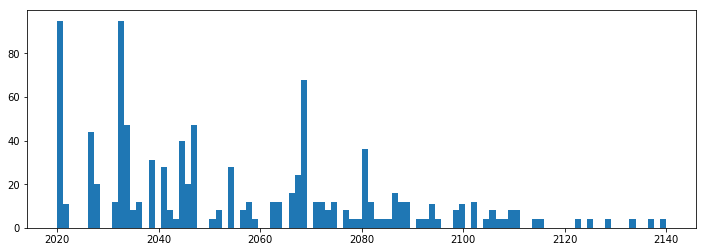

In [11]:
from multiprocessing import Pool
import time

A, n = parse_tsp("bays29.tsp")
T = 1000
I = 10000
hist = []
L = set()
E = set()


pool = Pool()
begin = time.time()
for s_res, L_, E_ in pool.map(CLK, [I]*T):
    hist.append(s_res)
    L = L | L_
    E = E | E_
    
print((time.time() - begin) * 100.0 / 60.0)
plt.figure(figsize=(12,4))
plt.hist(hist, bins=100)
plt.show()

In [16]:
import pickle

def save_graph(V, E, file_name):
    with open(file_name, "wb") as fh:
        pickle.dump((V, E), fh)
    
def load_graph(file_name):
    with open(file_name, "rb") as fh:
        (V, E) = pickle.load(fh)
        return V, E

In [13]:
import igraph

def print_graph(V, E, g_min):
    V_ = { s : (i, tsp_objective_function(s)) for i, s in enumerate(V)}
    E_ = [(V_[s1][0], V_[s2][0]) for s1, s2 in E]
    g = igraph.Graph()
    g.add_vertices(len(V))
    g.add_edges(E_)
    layout = g.layout_drl()
    igraph.summary(g)
    igraph.plot(g, layout=layout)._repr_svg_()
    
print_graph(L, E, 0)

IGRAPH U--- 4226 4072 -- 


In [17]:
save_graph(L, E, "bayes29.g")